In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [3]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3,
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

In [4]:
model = DeepMLP(input_size=3, hidden_size=6, output_size=7, n_hidden=1)
answer = sum(p.numel() for p in model.parameters())
answer   ### здесь должен быть выведен ответ

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [5]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

In [6]:
answer = model.hidden_layers[0].weight.grad.abs().mean().item() ### YOUR CODE HERE
answer   ### здесь должен быть выведен ответ

0.015551229007542133

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [7]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

In [8]:
test_data = torch.rand((1, 28*28)).to(device)

answer = model(test_data).sum().item()
answer   ### здесь должен быть выведен ответ

-0.5515778660774231

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [9]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 111364208.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4871343.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34349487.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21872019.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')

      fc_gradients.append(model.hidden_layers[0].weight.grad.abs().mean().item())  # <------ код из решения задачи 2

  return fc_gradients

In [11]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

  1%|          | 7/938 [00:00<01:30, 10.23it/s]

Step: 0, Loss: 2.2937896251678467


  2%|▏         | 15/938 [00:01<00:49, 18.66it/s]

Step: 10, Loss: 2.2889366149902344


  2%|▏         | 23/938 [00:01<00:41, 22.10it/s]

Step: 20, Loss: 2.291050672531128


  4%|▎         | 35/938 [00:01<00:39, 22.90it/s]

Step: 30, Loss: 2.154609441757202


  5%|▍         | 46/938 [00:02<00:32, 27.81it/s]

Step: 40, Loss: 2.016479015350342


  6%|▌         | 54/938 [00:02<00:30, 28.99it/s]

Step: 50, Loss: 1.8274005651474


  7%|▋         | 62/938 [00:02<00:27, 31.64it/s]

Step: 60, Loss: 1.6792889833450317


  8%|▊         | 75/938 [00:03<00:33, 25.87it/s]

Step: 70, Loss: 1.569961667060852


  9%|▉         | 85/938 [00:03<00:38, 22.40it/s]

Step: 80, Loss: 1.4565768241882324


 10%|█         | 95/938 [00:04<00:40, 20.88it/s]

Step: 90, Loss: 1.5084950923919678


 11%|█         | 105/938 [00:04<00:35, 23.70it/s]

Step: 100, Loss: 1.364181399345398


 12%|█▏        | 116/938 [00:05<00:29, 27.95it/s]

Step: 110, Loss: 1.395524501800537


 13%|█▎        | 124/938 [00:05<00:27, 29.61it/s]

Step: 120, Loss: 1.2927829027175903


 14%|█▍        | 133/938 [00:05<00:30, 26.18it/s]

Step: 130, Loss: 1.172381043434143


 15%|█▌        | 144/938 [00:06<00:29, 27.02it/s]

Step: 140, Loss: 1.2509260177612305


 16%|█▋        | 154/938 [00:06<00:28, 27.11it/s]

Step: 150, Loss: 1.1494622230529785


 17%|█▋        | 164/938 [00:06<00:27, 28.14it/s]

Step: 160, Loss: 1.1668161153793335


 18%|█▊        | 172/938 [00:07<00:29, 26.07it/s]

Step: 170, Loss: 1.220613956451416


 20%|█▉        | 184/938 [00:07<00:26, 28.61it/s]

Step: 180, Loss: 1.3069820404052734


 21%|██        | 196/938 [00:07<00:23, 31.67it/s]

Step: 190, Loss: 0.946485161781311


 22%|██▏       | 204/938 [00:08<00:23, 31.80it/s]

Step: 200, Loss: 0.8249154686927795


 23%|██▎       | 215/938 [00:08<00:26, 27.16it/s]

Step: 210, Loss: 1.3002018928527832


 24%|██▍       | 224/938 [00:08<00:22, 31.12it/s]

Step: 220, Loss: 1.1068321466445923


 25%|██▍       | 232/938 [00:09<00:24, 28.66it/s]

Step: 230, Loss: 1.0789337158203125


 26%|██▌       | 244/938 [00:09<00:25, 27.45it/s]

Step: 240, Loss: 1.1287155151367188


 27%|██▋       | 254/938 [00:10<00:29, 23.39it/s]

Step: 250, Loss: 1.045046091079712


 28%|██▊       | 264/938 [00:10<00:26, 25.89it/s]

Step: 260, Loss: 1.0151885747909546


 29%|██▉       | 274/938 [00:10<00:24, 26.62it/s]

Step: 270, Loss: 0.8476772308349609


 30%|███       | 286/938 [00:11<00:21, 30.02it/s]

Step: 280, Loss: 0.9521381258964539


 32%|███▏      | 297/938 [00:11<00:21, 30.39it/s]

Step: 290, Loss: 0.7699106335639954


 33%|███▎      | 305/938 [00:11<00:22, 27.89it/s]

Step: 300, Loss: 1.1782273054122925


 34%|███▎      | 315/938 [00:12<00:24, 24.99it/s]

Step: 310, Loss: 0.8225458860397339


 35%|███▍      | 325/938 [00:12<00:19, 31.54it/s]

Step: 320, Loss: 1.0159187316894531


 36%|███▌      | 336/938 [00:12<00:16, 36.99it/s]

Step: 330, Loss: 0.8963613510131836


 37%|███▋      | 344/938 [00:13<00:16, 35.30it/s]

Step: 340, Loss: 0.894009530544281


 38%|███▊      | 354/938 [00:13<00:15, 38.91it/s]

Step: 350, Loss: 0.8441407680511475


 39%|███▊      | 362/938 [00:13<00:22, 25.90it/s]

Step: 360, Loss: 0.8699902296066284


 40%|███▉      | 375/938 [00:14<00:19, 29.06it/s]

Step: 370, Loss: 0.9404324293136597


 41%|████      | 383/938 [00:14<00:20, 26.50it/s]

Step: 380, Loss: 0.8298032283782959


 42%|████▏     | 396/938 [00:15<00:22, 24.63it/s]

Step: 390, Loss: 0.8056067228317261


 43%|████▎     | 404/938 [00:15<00:18, 28.54it/s]

Step: 400, Loss: 0.9474304914474487


 44%|████▍     | 414/938 [00:15<00:20, 26.12it/s]

Step: 410, Loss: 0.8397301435470581


 45%|████▌     | 424/938 [00:16<00:21, 24.08it/s]

Step: 420, Loss: 0.7543426752090454


 47%|████▋     | 437/938 [00:16<00:19, 25.48it/s]

Step: 430, Loss: 0.7021985650062561


 48%|████▊     | 446/938 [00:16<00:14, 32.87it/s]

Step: 440, Loss: 0.6798675656318665


 49%|████▊     | 457/938 [00:17<00:11, 41.30it/s]

Step: 450, Loss: 0.6756791472434998


 50%|████▉     | 467/938 [00:17<00:12, 38.50it/s]

Step: 460, Loss: 0.9879452586174011


 51%|█████     | 475/938 [00:17<00:12, 36.51it/s]

Step: 470, Loss: 0.530322253704071


 52%|█████▏    | 484/938 [00:17<00:12, 35.72it/s]

Step: 480, Loss: 0.5808587074279785


 53%|█████▎    | 496/938 [00:18<00:13, 33.69it/s]

Step: 490, Loss: 0.695310652256012


 54%|█████▎    | 504/938 [00:18<00:16, 27.10it/s]

Step: 500, Loss: 0.8470647931098938


 55%|█████▍    | 514/938 [00:19<00:16, 24.98it/s]

Step: 510, Loss: 0.8692700862884521


 57%|█████▋    | 533/938 [00:19<00:09, 44.78it/s]

Step: 520, Loss: 0.9202135801315308
Step: 530, Loss: 0.9786092042922974


 59%|█████▉    | 552/938 [00:19<00:07, 54.97it/s]

Step: 540, Loss: 0.7890682816505432
Step: 550, Loss: 0.842555582523346


 60%|██████    | 565/938 [00:19<00:06, 53.46it/s]

Step: 560, Loss: 0.8212042450904846


 61%|██████▏   | 576/938 [00:20<00:08, 41.91it/s]

Step: 570, Loss: 1.0312821865081787


 62%|██████▏   | 585/938 [00:20<00:09, 36.88it/s]

Step: 580, Loss: 0.897013783454895


 63%|██████▎   | 594/938 [00:20<00:10, 34.10it/s]

Step: 590, Loss: 0.9745898246765137


 65%|██████▍   | 606/938 [00:21<00:09, 33.98it/s]

Step: 600, Loss: 0.614892303943634


 66%|██████▌   | 620/938 [00:21<00:06, 46.09it/s]

Step: 610, Loss: 0.8571321964263916
Step: 620, Loss: 0.5909349322319031


 68%|██████▊   | 641/938 [00:21<00:05, 55.74it/s]

Step: 630, Loss: 0.9711124897003174
Step: 640, Loss: 0.6752397418022156


 70%|███████   | 661/938 [00:22<00:04, 59.35it/s]

Step: 650, Loss: 0.793038547039032
Step: 660, Loss: 0.8021664619445801


 73%|███████▎  | 685/938 [00:22<00:03, 66.05it/s]

Step: 670, Loss: 0.6898663640022278
Step: 680, Loss: 0.9239345788955688


 75%|███████▍  | 701/938 [00:22<00:03, 66.69it/s]

Step: 690, Loss: 0.8560190200805664
Step: 700, Loss: 0.6427173614501953


 77%|███████▋  | 723/938 [00:23<00:03, 65.37it/s]

Step: 710, Loss: 0.7232307195663452
Step: 720, Loss: 0.8339681625366211


 79%|███████▊  | 738/938 [00:23<00:02, 68.40it/s]

Step: 730, Loss: 0.6960524320602417
Step: 740, Loss: 0.6204549670219421


 81%|████████  | 760/938 [00:23<00:02, 64.58it/s]

Step: 750, Loss: 0.3275142014026642
Step: 760, Loss: 0.655512809753418


 83%|████████▎ | 782/938 [00:23<00:02, 64.23it/s]

Step: 770, Loss: 0.6526492238044739
Step: 780, Loss: 0.5388124585151672


 85%|████████▍ | 797/938 [00:24<00:02, 64.26it/s]

Step: 790, Loss: 0.7175283432006836
Step: 800, Loss: 0.47889837622642517


 87%|████████▋ | 820/938 [00:24<00:01, 69.12it/s]

Step: 810, Loss: 0.5588071346282959
Step: 820, Loss: 0.600587785243988


 90%|████████▉ | 843/938 [00:24<00:01, 68.12it/s]

Step: 830, Loss: 0.6281799077987671
Step: 840, Loss: 0.4902746379375458


 92%|█████████▏| 866/938 [00:25<00:01, 69.22it/s]

Step: 850, Loss: 1.0378198623657227
Step: 860, Loss: 0.645628035068512


 94%|█████████▍| 881/938 [00:25<00:00, 67.18it/s]

Step: 870, Loss: 0.6482465863227844
Step: 880, Loss: 0.556383490562439


 96%|█████████▌| 897/938 [00:25<00:00, 67.39it/s]

Step: 890, Loss: 0.619185209274292
Step: 900, Loss: 0.7866921424865723


 98%|█████████▊| 920/938 [00:25<00:00, 68.75it/s]

Step: 910, Loss: 0.4500378370285034
Step: 920, Loss: 0.6020404696464539


100%|██████████| 938/938 [00:26<00:00, 35.76it/s]

Step: 930, Loss: 0.5132187008857727


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [12]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10  # YOUR ANSWER HERE
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

In [13]:
answer = len(model.hidden_layers)# YOUR CODE HERE
answer   ### здесь должен быть выведен ответ

10

In [14]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 11/938 [00:00<00:18, 51.17it/s]

Step: 0, Loss: 2.3116233348846436
Step: 10, Loss: 2.2927772998809814


  3%|▎         | 27/938 [00:00<00:20, 43.96it/s]

Step: 20, Loss: 2.328972816467285


  4%|▍         | 38/938 [00:00<00:20, 43.99it/s]

Step: 30, Loss: 2.3101611137390137


  5%|▌         | 48/938 [00:01<00:21, 42.09it/s]

Step: 40, Loss: 2.3166162967681885
Step: 50, Loss: 2.334524154663086


  7%|▋         | 64/938 [00:01<00:21, 39.79it/s]

Step: 60, Loss: 2.3023855686187744


  8%|▊         | 78/938 [00:01<00:22, 38.77it/s]

Step: 70, Loss: 2.3015942573547363


  9%|▉         | 86/938 [00:02<00:23, 36.81it/s]

Step: 80, Loss: 2.3111729621887207


 10%|█         | 96/938 [00:02<00:20, 41.12it/s]

Step: 90, Loss: 2.2827999591827393


 11%|█         | 105/938 [00:02<00:21, 39.08it/s]

Step: 100, Loss: 2.3095767498016357


 12%|█▏        | 114/938 [00:02<00:20, 39.67it/s]

Step: 110, Loss: 2.2963790893554688


 14%|█▍        | 130/938 [00:03<00:18, 44.32it/s]

Step: 120, Loss: 2.2688260078430176
Step: 130, Loss: 2.2773725986480713


 16%|█▌        | 148/938 [00:03<00:15, 50.89it/s]

Step: 140, Loss: 2.292206048965454
Step: 150, Loss: 2.307490348815918


 18%|█▊        | 168/938 [00:03<00:13, 57.16it/s]

Step: 160, Loss: 2.305772542953491
Step: 170, Loss: 2.2927846908569336


 20%|██        | 189/938 [00:04<00:12, 61.75it/s]

Step: 180, Loss: 2.2967801094055176
Step: 190, Loss: 2.303372383117676


 22%|██▏       | 203/938 [00:04<00:13, 52.88it/s]

Step: 200, Loss: 2.2963032722473145


 23%|██▎       | 215/938 [00:04<00:14, 50.15it/s]

Step: 210, Loss: 2.3021481037139893


 24%|██▍       | 226/938 [00:04<00:16, 43.97it/s]

Step: 220, Loss: 2.320111036300659


 25%|██▌       | 236/938 [00:05<00:16, 41.38it/s]

Step: 230, Loss: 2.296765089035034


 26%|██▌       | 246/938 [00:05<00:17, 38.51it/s]

Step: 240, Loss: 2.316693067550659


 27%|██▋       | 254/938 [00:05<00:18, 37.69it/s]

Step: 250, Loss: 2.300535202026367


 28%|██▊       | 264/938 [00:05<00:17, 38.66it/s]

Step: 260, Loss: 2.3093209266662598
Step: 270, Loss: 2.3047685623168945


 31%|███       | 293/938 [00:06<00:11, 57.08it/s]

Step: 280, Loss: 2.298886299133301
Step: 290, Loss: 2.2999866008758545


 33%|███▎      | 307/938 [00:06<00:10, 60.62it/s]

Step: 300, Loss: 2.3137307167053223
Step: 310, Loss: 2.2899208068847656


 35%|███▌      | 329/938 [00:07<00:09, 61.23it/s]

Step: 320, Loss: 2.300848960876465
Step: 330, Loss: 2.2937445640563965


 37%|███▋      | 350/938 [00:07<00:09, 61.01it/s]

Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367


 40%|███▉      | 371/938 [00:07<00:09, 62.72it/s]

Step: 360, Loss: 2.2795777320861816
Step: 370, Loss: 2.30194091796875


 41%|████      | 385/938 [00:07<00:08, 62.81it/s]

Step: 380, Loss: 2.303889513015747
Step: 390, Loss: 2.303920269012451


 44%|████▍     | 413/938 [00:08<00:08, 61.33it/s]

Step: 400, Loss: 2.319232940673828
Step: 410, Loss: 2.3047914505004883


 46%|████▋     | 434/938 [00:08<00:08, 62.05it/s]

Step: 420, Loss: 2.3087210655212402
Step: 430, Loss: 2.301931858062744


 48%|████▊     | 448/938 [00:08<00:08, 59.31it/s]

Step: 440, Loss: 2.3054850101470947


 49%|████▉     | 461/938 [00:09<00:08, 58.75it/s]

Step: 450, Loss: 2.3106305599212646
Step: 460, Loss: 2.2992072105407715


 51%|█████     | 475/938 [00:09<00:07, 58.97it/s]

Step: 470, Loss: 2.2997899055480957


 52%|█████▏    | 487/938 [00:09<00:10, 43.52it/s]

Step: 480, Loss: 2.287055015563965


 53%|█████▎    | 497/938 [00:10<00:10, 40.41it/s]

Step: 490, Loss: 2.3007149696350098


 54%|█████▍    | 506/938 [00:10<00:12, 34.69it/s]

Step: 500, Loss: 2.3059136867523193


 55%|█████▍    | 514/938 [00:10<00:12, 33.06it/s]

Step: 510, Loss: 2.306123971939087


 56%|█████▌    | 527/938 [00:10<00:09, 44.23it/s]

Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298402786254883


 58%|█████▊    | 548/938 [00:11<00:07, 53.58it/s]

Step: 540, Loss: 2.3022847175598145
Step: 550, Loss: 2.300930976867676


 61%|██████    | 570/938 [00:11<00:06, 61.02it/s]

Step: 560, Loss: 2.294130802154541
Step: 570, Loss: 2.3121466636657715


 63%|██████▎   | 591/938 [00:11<00:05, 63.33it/s]

Step: 580, Loss: 2.307267665863037
Step: 590, Loss: 2.3139259815216064


 65%|██████▌   | 613/938 [00:12<00:05, 62.83it/s]

Step: 600, Loss: 2.295274496078491
Step: 610, Loss: 2.3205597400665283


 67%|██████▋   | 627/938 [00:12<00:05, 61.54it/s]

Step: 620, Loss: 2.299974203109741
Step: 630, Loss: 2.311312437057495


 69%|██████▉   | 649/938 [00:12<00:04, 62.09it/s]

Step: 640, Loss: 2.2809948921203613
Step: 650, Loss: 2.298368215560913


 71%|███████▏  | 670/938 [00:13<00:04, 58.17it/s]

Step: 660, Loss: 2.306234121322632


 72%|███████▏  | 676/938 [00:13<00:05, 51.90it/s]

Step: 670, Loss: 2.292137384414673


 73%|███████▎  | 687/938 [00:13<00:05, 43.50it/s]

Step: 680, Loss: 2.3122923374176025


 74%|███████▍  | 698/938 [00:13<00:05, 45.19it/s]

Step: 690, Loss: 2.3026340007781982


 75%|███████▌  | 708/938 [00:14<00:05, 43.97it/s]

Step: 700, Loss: 2.3024537563323975


 77%|███████▋  | 718/938 [00:14<00:05, 41.85it/s]

Step: 710, Loss: 2.2988364696502686


 78%|███████▊  | 728/938 [00:14<00:05, 41.99it/s]

Step: 720, Loss: 2.316863775253296


 79%|███████▊  | 738/938 [00:14<00:05, 39.86it/s]

Step: 730, Loss: 2.3063321113586426


 80%|███████▉  | 748/938 [00:15<00:04, 41.14it/s]

Step: 740, Loss: 2.2941949367523193


 81%|████████  | 758/938 [00:15<00:04, 42.57it/s]

Step: 750, Loss: 2.2960398197174072


 82%|████████▏ | 768/938 [00:15<00:04, 39.62it/s]

Step: 760, Loss: 2.3012545108795166


 83%|████████▎ | 781/938 [00:15<00:03, 49.92it/s]

Step: 770, Loss: 2.3173434734344482
Step: 780, Loss: 2.292786121368408


 86%|████████▌ | 802/938 [00:16<00:02, 59.44it/s]

Step: 790, Loss: 2.2951321601867676
Step: 800, Loss: 2.2958858013153076


 87%|████████▋ | 816/938 [00:16<00:02, 59.50it/s]

Step: 810, Loss: 2.3131911754608154
Step: 820, Loss: 2.3094000816345215


 89%|████████▉ | 837/938 [00:16<00:01, 57.89it/s]

Step: 830, Loss: 2.3140485286712646
Step: 840, Loss: 2.3108716011047363


 92%|█████████▏| 859/938 [00:17<00:01, 62.07it/s]

Step: 850, Loss: 2.3054323196411133
Step: 860, Loss: 2.3024682998657227


 94%|█████████▍| 880/938 [00:17<00:00, 59.04it/s]

Step: 870, Loss: 2.2862768173217773
Step: 880, Loss: 2.297034978866577


 96%|█████████▌| 902/938 [00:17<00:00, 61.81it/s]

Step: 890, Loss: 2.303971529006958
Step: 900, Loss: 2.301696300506592


 98%|█████████▊| 923/938 [00:18<00:00, 64.13it/s]

Step: 910, Loss: 2.2977375984191895
Step: 920, Loss: 2.2961878776550293


100%|██████████| 938/938 [00:18<00:00, 51.04it/s]

Step: 930, Loss: 2.297501564025879


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

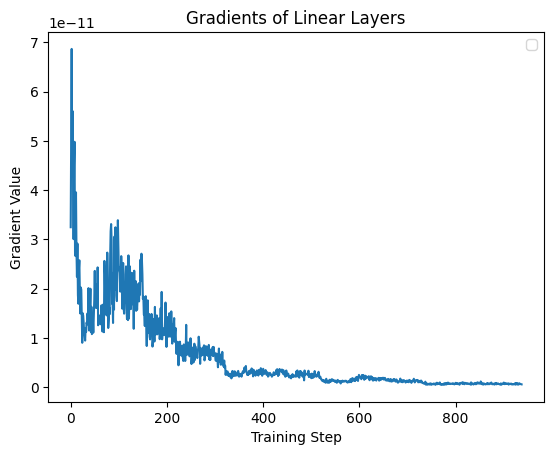

In [15]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно.

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [16]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
  def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input

**Пример ответа:** `0.234`

In [17]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [18]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model_relu(test_input).sum().item() ### YOUR CODE HERE
answer   ### здесь должен быть выведен ответ

-0.2832258641719818

In [19]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  1%|          | 11/938 [00:00<00:17, 53.42it/s]

Step: 0, Loss: 2.3037009239196777
Step: 10, Loss: 2.2954561710357666


  3%|▎         | 32/938 [00:00<00:14, 61.52it/s]

Step: 20, Loss: 2.302825689315796
Step: 30, Loss: 2.304784059524536


  5%|▍         | 46/938 [00:00<00:15, 56.61it/s]

Step: 40, Loss: 2.2691526412963867
Step: 50, Loss: 2.2142844200134277


  7%|▋         | 67/938 [00:01<00:15, 57.68it/s]

Step: 60, Loss: 1.9159643650054932
Step: 70, Loss: 1.9696029424667358


  9%|▉         | 88/938 [00:01<00:13, 63.27it/s]

Step: 80, Loss: 1.8537713289260864
Step: 90, Loss: 1.8757920265197754


 12%|█▏        | 109/938 [00:01<00:13, 60.56it/s]

Step: 100, Loss: 1.755249261856079
Step: 110, Loss: 1.9241080284118652


 14%|█▍        | 131/938 [00:02<00:12, 64.37it/s]

Step: 120, Loss: 1.6213148832321167
Step: 130, Loss: 1.592047929763794


 16%|█▌        | 152/938 [00:02<00:12, 63.95it/s]

Step: 140, Loss: 1.6301336288452148
Step: 150, Loss: 1.4148064851760864


 18%|█▊        | 166/938 [00:02<00:12, 64.31it/s]

Step: 160, Loss: 1.3613747358322144
Step: 170, Loss: 1.7583119869232178


 20%|██        | 188/938 [00:03<00:11, 63.32it/s]

Step: 180, Loss: 1.4944343566894531
Step: 190, Loss: 1.3037604093551636


 22%|██▏       | 209/938 [00:03<00:11, 62.28it/s]

Step: 200, Loss: 1.3115638494491577
Step: 210, Loss: 1.5537954568862915


 25%|██▍       | 230/938 [00:03<00:11, 61.72it/s]

Step: 220, Loss: 1.300612211227417
Step: 230, Loss: 1.347327709197998


 27%|██▋       | 252/938 [00:04<00:10, 63.16it/s]

Step: 240, Loss: 1.8815038204193115
Step: 250, Loss: 1.3414229154586792


 29%|██▉       | 273/938 [00:04<00:10, 64.16it/s]

Step: 260, Loss: 1.6142351627349854
Step: 270, Loss: 1.4904329776763916


 31%|███▏      | 294/938 [00:04<00:10, 63.78it/s]

Step: 280, Loss: 2.08734130859375
Step: 290, Loss: 2.2944140434265137


 33%|███▎      | 308/938 [00:05<00:10, 59.97it/s]

Step: 300, Loss: 1.989254355430603
Step: 310, Loss: 1.7364696264266968


 35%|███▍      | 328/938 [00:05<00:10, 59.40it/s]

Step: 320, Loss: 1.6963292360305786
Step: 330, Loss: 1.570088505744934


 37%|███▋      | 350/938 [00:05<00:09, 62.72it/s]

Step: 340, Loss: 1.4915575981140137
Step: 350, Loss: 1.6097455024719238


 40%|███▉      | 371/938 [00:06<00:09, 59.88it/s]

Step: 360, Loss: 1.5979137420654297
Step: 370, Loss: 1.5623785257339478


 42%|████▏     | 392/938 [00:06<00:08, 62.17it/s]

Step: 380, Loss: 1.485694408416748
Step: 390, Loss: 1.3820677995681763


 44%|████▍     | 414/938 [00:06<00:08, 63.72it/s]

Step: 400, Loss: 1.5611592531204224
Step: 410, Loss: 1.4013158082962036


 46%|████▌     | 428/938 [00:07<00:09, 54.07it/s]

Step: 420, Loss: 1.451932668685913


 46%|████▋     | 434/938 [00:07<00:10, 49.52it/s]

Step: 430, Loss: 1.3206346035003662


 48%|████▊     | 451/938 [00:07<00:10, 47.88it/s]

Step: 440, Loss: 1.4083579778671265
Step: 450, Loss: 1.3467603921890259


 50%|████▉     | 467/938 [00:07<00:10, 46.52it/s]

Step: 460, Loss: 1.388302206993103


 51%|█████     | 477/938 [00:08<00:10, 43.70it/s]

Step: 470, Loss: 1.1975218057632446


 52%|█████▏    | 487/938 [00:08<00:11, 39.99it/s]

Step: 480, Loss: 1.322036862373352


 53%|█████▎    | 497/938 [00:08<00:10, 40.86it/s]

Step: 490, Loss: 1.2698763608932495


 54%|█████▍    | 508/938 [00:08<00:10, 39.92it/s]

Step: 500, Loss: 1.2775744199752808


 55%|█████▍    | 513/938 [00:09<00:10, 39.60it/s]

Step: 510, Loss: 1.5005029439926147


 56%|█████▋    | 529/938 [00:09<00:09, 43.25it/s]

Step: 520, Loss: 1.6284371614456177
Step: 530, Loss: 1.3923218250274658


 59%|█████▊    | 550/938 [00:09<00:06, 56.33it/s]

Step: 540, Loss: 1.2296490669250488
Step: 550, Loss: 1.216318130493164


 61%|██████    | 568/938 [00:10<00:06, 57.56it/s]

Step: 560, Loss: 1.3948431015014648
Step: 570, Loss: 1.504318118095398


 63%|██████▎   | 589/938 [00:10<00:05, 62.81it/s]

Step: 580, Loss: 1.2066500186920166
Step: 590, Loss: 1.6481425762176514


 65%|██████▌   | 611/938 [00:10<00:05, 61.53it/s]

Step: 600, Loss: 1.1961365938186646
Step: 610, Loss: 1.1553452014923096


 67%|██████▋   | 625/938 [00:11<00:05, 61.93it/s]

Step: 620, Loss: 1.3278205394744873
Step: 630, Loss: 1.9986506700515747


 70%|██████▉   | 653/938 [00:11<00:04, 60.61it/s]

Step: 640, Loss: 1.1789354085922241
Step: 650, Loss: 1.118448257446289


 71%|███████   | 667/938 [00:11<00:04, 60.32it/s]

Step: 660, Loss: 1.355739951133728
Step: 670, Loss: 1.2797014713287354


 74%|███████▎  | 690/938 [00:12<00:03, 64.50it/s]

Step: 680, Loss: 1.4839719533920288
Step: 690, Loss: 1.3770241737365723


 76%|███████▌  | 713/938 [00:12<00:03, 62.54it/s]

Step: 700, Loss: 1.576735019683838
Step: 710, Loss: 1.2814499139785767


 78%|███████▊  | 734/938 [00:12<00:03, 63.72it/s]

Step: 720, Loss: 4.790157318115234
Step: 730, Loss: 1.3061635494232178


 80%|███████▉  | 748/938 [00:13<00:03, 61.22it/s]

Step: 740, Loss: 1.2562466859817505
Step: 750, Loss: 1.035500168800354


 82%|████████▏ | 768/938 [00:13<00:02, 58.88it/s]

Step: 760, Loss: 1.2243064641952515
Step: 770, Loss: 1.2910391092300415


 84%|████████▍ | 787/938 [00:13<00:02, 60.95it/s]

Step: 780, Loss: 1.197306513786316
Step: 790, Loss: 1.270922064781189


 86%|████████▌ | 809/938 [00:14<00:01, 64.71it/s]

Step: 800, Loss: 1.152504563331604
Step: 810, Loss: 1.0426437854766846


 88%|████████▊ | 830/938 [00:14<00:01, 62.32it/s]

Step: 820, Loss: 1.4269789457321167
Step: 830, Loss: 1.0927705764770508


 91%|█████████ | 851/938 [00:14<00:01, 60.57it/s]

Step: 840, Loss: 1.0427659749984741
Step: 850, Loss: 1.4467620849609375


 93%|█████████▎| 872/938 [00:15<00:01, 63.13it/s]

Step: 860, Loss: 0.9785715341567993
Step: 870, Loss: 1.0249103307724


 95%|█████████▌| 893/938 [00:15<00:00, 61.84it/s]

Step: 880, Loss: 0.9940614104270935
Step: 890, Loss: 1.119301438331604


 97%|█████████▋| 907/938 [00:15<00:00, 58.40it/s]

Step: 900, Loss: 1.4805970191955566
Step: 910, Loss: 1.1320809125900269


 99%|█████████▉| 929/938 [00:16<00:00, 62.15it/s]

Step: 920, Loss: 0.9201682806015015
Step: 930, Loss: 1.3256943225860596


100%|██████████| 938/938 [00:16<00:00, 58.03it/s]


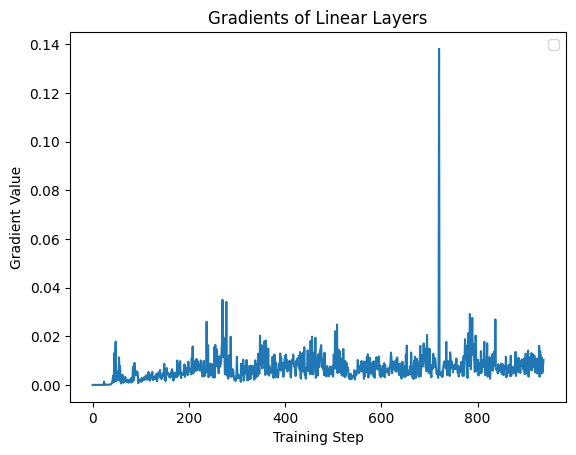

In [20]:
# Визуализируйте градинте:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [21]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

In [22]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_input).sum().item() # YOUR CODE HERE
answer   ### здесь должен быть выведен ответ

-0.9367365837097168

In [23]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 8/938 [00:00<00:22, 41.59it/s]

Step: 0, Loss: 2.370612144470215
Step: 10, Loss: 2.319352149963379


  3%|▎         | 27/938 [00:00<00:16, 55.29it/s]

Step: 20, Loss: 2.384559392929077
Step: 30, Loss: 2.322371482849121


  5%|▍         | 45/938 [00:00<00:18, 48.96it/s]

Step: 40, Loss: 2.3334951400756836
Step: 50, Loss: 2.335846185684204


  8%|▊         | 71/938 [00:01<00:16, 53.30it/s]

Step: 60, Loss: 2.337700843811035
Step: 70, Loss: 2.294940948486328


  9%|▉         | 89/938 [00:01<00:16, 51.45it/s]

Step: 80, Loss: 2.3135998249053955


 11%|█         | 101/938 [00:01<00:16, 50.32it/s]

Step: 90, Loss: 2.3037660121917725
Step: 100, Loss: 2.3035049438476562


 13%|█▎        | 119/938 [00:02<00:14, 54.87it/s]

Step: 110, Loss: 2.311680316925049
Step: 120, Loss: 2.2950565814971924


 15%|█▍        | 138/938 [00:02<00:14, 56.30it/s]

Step: 130, Loss: 2.2916624546051025
Step: 140, Loss: 2.303668260574341


 17%|█▋        | 156/938 [00:03<00:16, 46.92it/s]

Step: 150, Loss: 2.308089017868042


 18%|█▊        | 167/938 [00:03<00:16, 45.37it/s]

Step: 160, Loss: 2.294508457183838


 19%|█▉        | 177/938 [00:03<00:18, 41.56it/s]

Step: 170, Loss: 2.299661636352539


 20%|█▉        | 187/938 [00:03<00:18, 40.29it/s]

Step: 180, Loss: 2.30952787399292


 21%|██        | 198/938 [00:04<00:17, 41.24it/s]

Step: 190, Loss: 2.3046488761901855


 22%|██▏       | 208/938 [00:04<00:18, 39.92it/s]

Step: 200, Loss: 2.2925260066986084


 23%|██▎       | 217/938 [00:04<00:20, 35.40it/s]

Step: 210, Loss: 2.297971725463867


 24%|██▍       | 226/938 [00:04<00:18, 38.22it/s]

Step: 220, Loss: 2.3187084197998047


 25%|██▌       | 238/938 [00:05<00:19, 36.34it/s]

Step: 230, Loss: 2.296956777572632


 26%|██▌       | 246/938 [00:05<00:18, 36.68it/s]

Step: 240, Loss: 2.320816993713379


 28%|██▊       | 258/938 [00:05<00:14, 47.29it/s]

Step: 250, Loss: 2.3015003204345703
Step: 260, Loss: 2.3070170879364014


 29%|██▉       | 276/938 [00:05<00:12, 52.80it/s]

Step: 270, Loss: 2.304478406906128
Step: 280, Loss: 2.3052568435668945


 32%|███▏      | 300/938 [00:06<00:11, 53.88it/s]

Step: 290, Loss: 2.3059661388397217
Step: 300, Loss: 2.3120131492614746


 34%|███▍      | 318/938 [00:06<00:11, 54.24it/s]

Step: 310, Loss: 2.291264057159424
Step: 320, Loss: 2.298677682876587


 36%|███▌      | 337/938 [00:07<00:10, 56.63it/s]

Step: 330, Loss: 2.296095609664917
Step: 340, Loss: 2.305849313735962


 38%|███▊      | 356/938 [00:07<00:10, 57.73it/s]

Step: 350, Loss: 2.3076021671295166
Step: 360, Loss: 2.2834110260009766


 41%|████      | 381/938 [00:07<00:09, 56.71it/s]

Step: 370, Loss: 2.298788547515869
Step: 380, Loss: 2.303243398666382


 43%|████▎     | 399/938 [00:08<00:09, 56.07it/s]

Step: 390, Loss: 2.30169415473938
Step: 400, Loss: 2.3153207302093506


 45%|████▍     | 418/938 [00:08<00:09, 56.23it/s]

Step: 410, Loss: 2.3035590648651123
Step: 420, Loss: 2.306709051132202


 47%|████▋     | 442/938 [00:08<00:08, 56.68it/s]

Step: 430, Loss: 2.301382064819336
Step: 440, Loss: 2.3099207878112793


 49%|████▉     | 460/938 [00:09<00:08, 56.32it/s]

Step: 450, Loss: 2.3080391883850098
Step: 460, Loss: 2.2981133460998535


 51%|█████     | 478/938 [00:09<00:08, 54.51it/s]

Step: 470, Loss: 2.296691417694092
Step: 480, Loss: 2.2905995845794678


 54%|█████▎    | 502/938 [00:10<00:07, 55.95it/s]

Step: 490, Loss: 2.301241874694824
Step: 500, Loss: 2.303941249847412


 56%|█████▌    | 523/938 [00:10<00:07, 57.72it/s]

Step: 510, Loss: 2.3054370880126953
Step: 520, Loss: 2.295976161956787


 58%|█████▊    | 541/938 [00:10<00:07, 55.48it/s]

Step: 530, Loss: 2.29780912399292
Step: 540, Loss: 2.3027031421661377


 60%|█████▉    | 560/938 [00:11<00:06, 57.39it/s]

Step: 550, Loss: 2.3001866340637207
Step: 560, Loss: 2.296241283416748


 62%|██████▏   | 579/938 [00:11<00:06, 56.97it/s]

Step: 570, Loss: 2.3105454444885254
Step: 580, Loss: 2.3034372329711914


 64%|██████▎   | 597/938 [00:11<00:06, 56.57it/s]

Step: 590, Loss: 2.313382625579834
Step: 600, Loss: 2.293776750564575


 66%|██████▌   | 621/938 [00:12<00:06, 52.20it/s]

Step: 610, Loss: 2.31894588470459
Step: 620, Loss: 2.3001785278320312


 68%|██████▊   | 640/938 [00:12<00:05, 55.74it/s]

Step: 630, Loss: 2.309185266494751
Step: 640, Loss: 2.2854819297790527


 70%|███████   | 658/938 [00:12<00:05, 54.37it/s]

Step: 650, Loss: 2.299595355987549
Step: 660, Loss: 2.3087782859802246


 73%|███████▎  | 682/938 [00:13<00:04, 54.51it/s]

Step: 670, Loss: 2.292625665664673
Step: 680, Loss: 2.312490224838257


 75%|███████▍  | 701/938 [00:13<00:04, 56.65it/s]

Step: 690, Loss: 2.3027215003967285
Step: 700, Loss: 2.3031020164489746


 77%|███████▋  | 719/938 [00:13<00:03, 57.38it/s]

Step: 710, Loss: 2.2977705001831055
Step: 720, Loss: 2.310284376144409


 79%|███████▊  | 738/938 [00:14<00:03, 57.81it/s]

Step: 730, Loss: 2.3078012466430664
Step: 740, Loss: 2.2944319248199463


 81%|████████  | 756/938 [00:14<00:03, 53.62it/s]

Step: 750, Loss: 2.296509027481079
Step: 760, Loss: 2.3016974925994873


 83%|████████▎ | 781/938 [00:15<00:02, 54.55it/s]

Step: 770, Loss: 2.315286636352539
Step: 780, Loss: 2.292431116104126


 85%|████████▌ | 800/938 [00:15<00:02, 55.41it/s]

Step: 790, Loss: 2.2961673736572266
Step: 800, Loss: 2.297883987426758


 87%|████████▋ | 816/938 [00:15<00:03, 40.54it/s]

Step: 810, Loss: 2.3135786056518555


 88%|████████▊ | 827/938 [00:16<00:02, 43.99it/s]

Step: 820, Loss: 2.307420253753662


 89%|████████▉ | 837/938 [00:16<00:02, 41.32it/s]

Step: 830, Loss: 2.3165266513824463


 90%|█████████ | 846/938 [00:16<00:02, 38.88it/s]

Step: 840, Loss: 2.305375337600708


 91%|█████████ | 854/938 [00:16<00:02, 39.19it/s]

Step: 850, Loss: 2.3068716526031494


 93%|█████████▎| 868/938 [00:17<00:01, 40.40it/s]

Step: 860, Loss: 2.3002524375915527


 93%|█████████▎| 877/938 [00:17<00:01, 37.33it/s]

Step: 870, Loss: 2.2848072052001953


 94%|█████████▍| 886/938 [00:17<00:01, 40.17it/s]

Step: 880, Loss: 2.3027474880218506


 95%|█████████▌| 895/938 [00:17<00:01, 34.93it/s]

Step: 890, Loss: 2.299281358718872


 97%|█████████▋| 908/938 [00:18<00:00, 45.69it/s]

Step: 900, Loss: 2.303833246231079
Step: 910, Loss: 2.2965760231018066


 99%|█████████▉| 931/938 [00:18<00:00, 52.77it/s]

Step: 920, Loss: 2.2989602088928223
Step: 930, Loss: 2.294469118118286


100%|██████████| 938/938 [00:18<00:00, 50.21it/s]


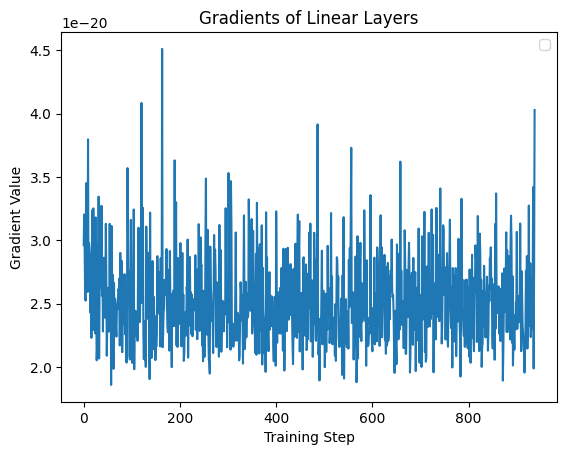

In [24]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [26]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10,10) # YOUR CODE HERE
answer = res_block(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(16789.0645, grad_fn=<SumBackward0>)

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [27]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

In [28]:
model = ResNet()
answer = sum(p.numel() for p in model.parameters()) # YOUR CODE HERE
answer   ### здесь должен быть выведен ответ

2799114

In [29]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  0%|          | 2/938 [00:01<07:58,  1.96it/s]

Step: 0, Loss: 2.4625658988952637


  1%|▏         | 12/938 [00:02<02:00,  7.66it/s]

Step: 10, Loss: 4.518246173858643


  2%|▏         | 22/938 [00:03<01:54,  8.00it/s]

Step: 20, Loss: 1.738263726234436


  3%|▎         | 32/938 [00:04<01:52,  8.07it/s]

Step: 30, Loss: 1.269822597503662


  4%|▍         | 42/938 [00:06<01:51,  8.03it/s]

Step: 40, Loss: 1.1356000900268555


  6%|▌         | 52/938 [00:07<01:50,  8.03it/s]

Step: 50, Loss: 0.9595915079116821


  7%|▋         | 62/938 [00:08<01:49,  7.98it/s]

Step: 60, Loss: 0.49534860253334045


  8%|▊         | 72/938 [00:09<01:52,  7.69it/s]

Step: 70, Loss: 0.2686518132686615


  9%|▊         | 82/938 [00:11<01:50,  7.78it/s]

Step: 80, Loss: 0.5311979651451111


 10%|▉         | 92/938 [00:12<01:46,  7.96it/s]

Step: 90, Loss: 0.329017698764801


 11%|█         | 102/938 [00:13<01:45,  7.95it/s]

Step: 100, Loss: 0.4706745147705078


 12%|█▏        | 112/938 [00:15<01:44,  7.93it/s]

Step: 110, Loss: 0.41078680753707886


 13%|█▎        | 122/938 [00:16<01:42,  7.98it/s]

Step: 120, Loss: 0.4007105529308319


 14%|█▍        | 132/938 [00:17<01:41,  7.94it/s]

Step: 130, Loss: 0.2179172933101654


 15%|█▌        | 142/938 [00:18<01:40,  7.93it/s]

Step: 140, Loss: 0.25437694787979126


 16%|█▌        | 152/938 [00:20<01:39,  7.90it/s]

Step: 150, Loss: 0.11227300763130188


 17%|█▋        | 162/938 [00:21<01:48,  7.16it/s]

Step: 160, Loss: 0.20822539925575256


 18%|█▊        | 172/938 [00:22<01:40,  7.64it/s]

Step: 170, Loss: 0.501527726650238


 19%|█▉        | 182/938 [00:24<01:37,  7.79it/s]

Step: 180, Loss: 0.2078048288822174


 20%|██        | 192/938 [00:25<01:34,  7.87it/s]

Step: 190, Loss: 0.24439305067062378


 22%|██▏       | 202/938 [00:26<01:33,  7.85it/s]

Step: 200, Loss: 0.093582883477211


 23%|██▎       | 212/938 [00:27<01:32,  7.85it/s]

Step: 210, Loss: 0.3177211880683899


 24%|██▎       | 222/938 [00:29<01:31,  7.85it/s]

Step: 220, Loss: 0.09502117335796356


 25%|██▍       | 232/938 [00:30<01:30,  7.84it/s]

Step: 230, Loss: 0.13131742179393768


 26%|██▌       | 242/938 [00:31<01:28,  7.82it/s]

Step: 240, Loss: 0.03121289610862732


 27%|██▋       | 252/938 [00:32<01:27,  7.81it/s]

Step: 250, Loss: 0.03543666750192642


 28%|██▊       | 262/938 [00:34<01:30,  7.49it/s]

Step: 260, Loss: 0.07169422507286072


 29%|██▉       | 272/938 [00:35<01:28,  7.52it/s]

Step: 270, Loss: 0.046847324818372726


 30%|███       | 282/938 [00:36<01:27,  7.46it/s]

Step: 280, Loss: 0.10396914929151535


 31%|███       | 292/938 [00:38<01:24,  7.64it/s]

Step: 290, Loss: 0.12134167551994324


 32%|███▏      | 302/938 [00:39<01:22,  7.75it/s]

Step: 300, Loss: 0.22970770299434662


 33%|███▎      | 312/938 [00:40<01:20,  7.73it/s]

Step: 310, Loss: 0.17967498302459717


 34%|███▍      | 322/938 [00:42<01:19,  7.71it/s]

Step: 320, Loss: 0.23425030708312988


 35%|███▌      | 332/938 [00:43<01:19,  7.64it/s]

Step: 330, Loss: 0.05307590961456299


 36%|███▋      | 342/938 [00:44<01:17,  7.65it/s]

Step: 340, Loss: 0.16267003118991852


 38%|███▊      | 352/938 [00:46<01:19,  7.35it/s]

Step: 350, Loss: 0.045850809663534164


 39%|███▊      | 362/938 [00:47<01:18,  7.34it/s]

Step: 360, Loss: 0.1078321561217308


 40%|███▉      | 372/938 [00:48<01:14,  7.59it/s]

Step: 370, Loss: 0.023386016488075256


 41%|████      | 382/938 [00:50<01:12,  7.68it/s]

Step: 380, Loss: 0.08378167450428009


 42%|████▏     | 392/938 [00:51<01:11,  7.64it/s]

Step: 390, Loss: 0.20356301963329315


 43%|████▎     | 402/938 [00:52<01:10,  7.61it/s]

Step: 400, Loss: 0.26487037539482117


 44%|████▍     | 412/938 [00:54<01:09,  7.60it/s]

Step: 410, Loss: 0.06036217883229256


 45%|████▍     | 422/938 [00:55<01:10,  7.33it/s]

Step: 420, Loss: 0.16742362082004547


 46%|████▌     | 432/938 [00:56<01:06,  7.56it/s]

Step: 430, Loss: 0.03484487161040306


 47%|████▋     | 442/938 [00:58<01:08,  7.26it/s]

Step: 440, Loss: 0.15542447566986084


 48%|████▊     | 452/938 [00:59<01:06,  7.31it/s]

Step: 450, Loss: 0.17452788352966309


 49%|████▉     | 462/938 [01:00<01:08,  6.96it/s]

Step: 460, Loss: 0.09254178404808044


 50%|█████     | 472/938 [01:02<01:04,  7.23it/s]

Step: 470, Loss: 0.07504624128341675


 51%|█████▏    | 482/938 [01:03<01:06,  6.81it/s]

Step: 480, Loss: 0.07910826057195663


 52%|█████▏    | 492/938 [01:05<01:03,  7.08it/s]

Step: 490, Loss: 0.02556190825998783


 54%|█████▎    | 502/938 [01:06<01:02,  6.97it/s]

Step: 500, Loss: 0.15817812085151672


 55%|█████▍    | 512/938 [01:07<01:02,  6.81it/s]

Step: 510, Loss: 0.08191150426864624


 56%|█████▌    | 522/938 [01:09<00:56,  7.40it/s]

Step: 520, Loss: 0.18000824749469757


 57%|█████▋    | 532/938 [01:10<00:55,  7.26it/s]

Step: 530, Loss: 0.1399320811033249


 58%|█████▊    | 542/938 [01:12<00:56,  7.00it/s]

Step: 540, Loss: 0.10343324393033981


 59%|█████▉    | 552/938 [01:13<00:52,  7.36it/s]

Step: 550, Loss: 0.056356873363256454


 60%|█████▉    | 562/938 [01:14<00:53,  7.08it/s]

Step: 560, Loss: 0.08870232850313187


 61%|██████    | 572/938 [01:16<00:51,  7.10it/s]

Step: 570, Loss: 0.06399626284837723


 62%|██████▏   | 582/938 [01:17<00:49,  7.19it/s]

Step: 580, Loss: 0.2742476761341095


 63%|██████▎   | 592/938 [01:19<00:47,  7.28it/s]

Step: 590, Loss: 0.3242108225822449


 64%|██████▍   | 602/938 [01:20<00:46,  7.29it/s]

Step: 600, Loss: 0.16571174561977386


 65%|██████▌   | 612/938 [01:21<00:43,  7.45it/s]

Step: 610, Loss: 0.045568615198135376


 66%|██████▋   | 622/938 [01:23<00:46,  6.77it/s]

Step: 620, Loss: 0.12007740139961243


 67%|██████▋   | 632/938 [01:24<00:42,  7.13it/s]

Step: 630, Loss: 0.28831806778907776


 68%|██████▊   | 642/938 [01:26<00:41,  7.18it/s]

Step: 640, Loss: 0.022440629079937935


 70%|██████▉   | 652/938 [01:27<00:39,  7.30it/s]

Step: 650, Loss: 0.08813675493001938


 71%|███████   | 662/938 [01:28<00:38,  7.16it/s]

Step: 660, Loss: 0.05368005111813545


 72%|███████▏  | 672/938 [01:30<00:36,  7.35it/s]

Step: 670, Loss: 0.04135739058256149


 73%|███████▎  | 682/938 [01:31<00:35,  7.27it/s]

Step: 680, Loss: 0.10660002380609512


 74%|███████▍  | 692/938 [01:32<00:34,  7.20it/s]

Step: 690, Loss: 0.16755174100399017


 75%|███████▍  | 702/938 [01:34<00:33,  7.13it/s]

Step: 700, Loss: 0.026629021391272545


 76%|███████▌  | 712/938 [01:35<00:33,  6.84it/s]

Step: 710, Loss: 0.2717767357826233


 77%|███████▋  | 722/938 [01:37<00:31,  6.76it/s]

Step: 720, Loss: 0.03412790223956108


 78%|███████▊  | 732/938 [01:38<00:28,  7.12it/s]

Step: 730, Loss: 0.11163737624883652


 79%|███████▉  | 742/938 [01:40<00:27,  7.10it/s]

Step: 740, Loss: 0.08246417343616486


 80%|████████  | 752/938 [01:41<00:25,  7.24it/s]

Step: 750, Loss: 0.028961259871721268


 81%|████████  | 762/938 [01:42<00:24,  7.17it/s]

Step: 760, Loss: 0.053677819669246674


 82%|████████▏ | 772/938 [01:44<00:22,  7.37it/s]

Step: 770, Loss: 0.07263647764921188


 83%|████████▎ | 782/938 [01:45<00:21,  7.35it/s]

Step: 780, Loss: 0.16286179423332214


 84%|████████▍ | 792/938 [01:47<00:20,  7.22it/s]

Step: 790, Loss: 0.11233209073543549


 86%|████████▌ | 802/938 [01:48<00:19,  7.08it/s]

Step: 800, Loss: 0.06682779639959335


 87%|████████▋ | 812/938 [01:49<00:18,  6.81it/s]

Step: 810, Loss: 0.019487010315060616


 88%|████████▊ | 822/938 [01:51<00:15,  7.30it/s]

Step: 820, Loss: 0.11655867844820023


 89%|████████▊ | 832/938 [01:52<00:14,  7.35it/s]

Step: 830, Loss: 0.07486889511346817


 90%|████████▉ | 842/938 [01:53<00:13,  7.33it/s]

Step: 840, Loss: 0.19164952635765076


 91%|█████████ | 852/938 [01:55<00:11,  7.35it/s]

Step: 850, Loss: 0.09613031893968582


 92%|█████████▏| 862/938 [01:56<00:10,  7.18it/s]

Step: 860, Loss: 0.05424438416957855


 93%|█████████▎| 872/938 [01:58<00:09,  7.17it/s]

Step: 870, Loss: 0.18393221497535706


 94%|█████████▍| 882/938 [01:59<00:07,  7.25it/s]

Step: 880, Loss: 0.0175497904419899


 95%|█████████▌| 892/938 [02:00<00:06,  7.10it/s]

Step: 890, Loss: 0.015023146755993366


 96%|█████████▌| 902/938 [02:02<00:05,  6.94it/s]

Step: 900, Loss: 0.10535337030887604


 97%|█████████▋| 912/938 [02:03<00:03,  7.05it/s]

Step: 910, Loss: 0.07501750439405441


 98%|█████████▊| 922/938 [02:05<00:02,  7.05it/s]

Step: 920, Loss: 0.012605985626578331


 99%|█████████▉| 932/938 [02:06<00:00,  7.20it/s]

Step: 930, Loss: 0.1376464068889618


100%|██████████| 938/938 [02:07<00:00,  7.36it/s]


Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

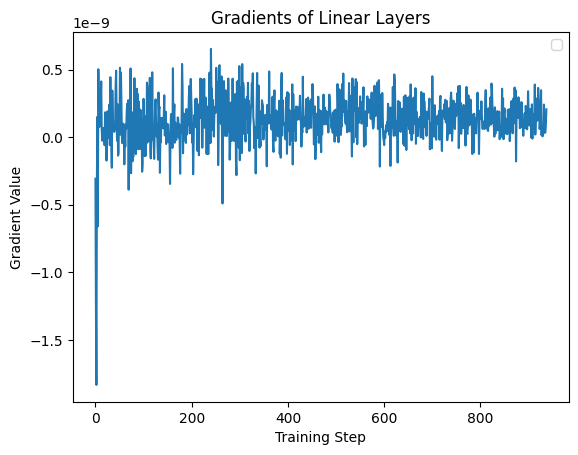

In [31]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [32]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [33]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [34]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [35]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

In [36]:
accuracy = test(model, testloader) # YOUR CODE HERE
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 938/938 [00:43<00:00, 21.77it/s]


MNIST test accuracy: 75.51666666666667%


Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [38]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [39]:
accuracy = test(model, testloader_cifar10) # YOUR CODE HERE
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.72it/s]


Test accuracy: 8.67%


Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [40]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)

mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

In [45]:
frozen_params = sum(p.numel() for p in model.parameters() if p.requires_grad==False) # YOUR CODE HERE
frozen_params   ### здесь должен быть выведен ответ

2776064

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [46]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

  1%|          | 4/782 [00:00<00:43, 18.01it/s]

Step: 0, Loss: 2.310819149017334


  2%|▏         | 16/782 [00:00<00:35, 21.35it/s]

Step: 10, Loss: 2.5238428115844727


  3%|▎         | 25/782 [00:01<00:36, 21.01it/s]

Step: 20, Loss: 2.2523744106292725


  4%|▍         | 34/782 [00:01<00:34, 21.54it/s]

Step: 30, Loss: 2.131202459335327


  6%|▌         | 46/782 [00:02<00:34, 21.34it/s]

Step: 40, Loss: 1.9906198978424072


  7%|▋         | 55/782 [00:02<00:34, 21.11it/s]

Step: 50, Loss: 2.090892791748047


  8%|▊         | 64/782 [00:03<00:33, 21.71it/s]

Step: 60, Loss: 2.2180488109588623


 10%|▉         | 76/782 [00:03<00:33, 21.04it/s]

Step: 70, Loss: 1.8151371479034424


 11%|█         | 85/782 [00:04<00:32, 21.23it/s]

Step: 80, Loss: 2.1018292903900146


 12%|█▏        | 94/782 [00:04<00:32, 20.96it/s]

Step: 90, Loss: 2.071200370788574


 14%|█▎        | 106/782 [00:05<00:31, 21.19it/s]

Step: 100, Loss: 1.8124910593032837


 15%|█▍        | 115/782 [00:05<00:32, 20.42it/s]

Step: 110, Loss: 2.104970932006836


 16%|█▌        | 124/782 [00:05<00:30, 21.36it/s]

Step: 120, Loss: 1.662699818611145


 17%|█▋        | 133/782 [00:06<00:31, 20.42it/s]

Step: 130, Loss: 2.209632396697998


 19%|█▊        | 145/782 [00:06<00:30, 20.77it/s]

Step: 140, Loss: 2.287121057510376


 20%|█▉        | 154/782 [00:07<00:30, 20.57it/s]

Step: 150, Loss: 2.0067765712738037


 21%|██        | 166/782 [00:08<00:29, 21.19it/s]

Step: 160, Loss: 2.060314655303955


 22%|██▏       | 175/782 [00:08<00:30, 20.16it/s]

Step: 170, Loss: 2.1484930515289307


 24%|██▎       | 184/782 [00:08<00:28, 20.76it/s]

Step: 180, Loss: 1.7093662023544312


 25%|██▍       | 193/782 [00:09<00:29, 20.07it/s]

Step: 190, Loss: 2.1678214073181152


 26%|██▌       | 205/782 [00:09<00:27, 21.03it/s]

Step: 200, Loss: 2.1678175926208496


 27%|██▋       | 214/782 [00:10<00:26, 21.18it/s]

Step: 210, Loss: 1.7193238735198975


 29%|██▉       | 226/782 [00:10<00:26, 20.66it/s]

Step: 220, Loss: 1.9669853448867798


 30%|███       | 235/782 [00:11<00:27, 20.24it/s]

Step: 230, Loss: 1.731612205505371


 31%|███       | 244/782 [00:11<00:26, 20.68it/s]

Step: 240, Loss: 1.8260895013809204


 32%|███▏      | 253/782 [00:12<00:26, 20.23it/s]

Step: 250, Loss: 1.7370929718017578


 34%|███▍      | 265/782 [00:12<00:25, 20.39it/s]

Step: 260, Loss: 2.0057671070098877


 35%|███▌      | 274/782 [00:13<00:24, 20.67it/s]

Step: 270, Loss: 2.256600856781006


 37%|███▋      | 286/782 [00:13<00:24, 20.25it/s]

Step: 280, Loss: 2.134054183959961


 38%|███▊      | 295/782 [00:14<00:23, 20.34it/s]

Step: 290, Loss: 1.8755054473876953


 39%|███▉      | 304/782 [00:14<00:23, 20.39it/s]

Step: 300, Loss: 1.9234007596969604


 40%|████      | 313/782 [00:15<00:23, 20.30it/s]

Step: 310, Loss: 1.7397652864456177


 42%|████▏     | 325/782 [00:15<00:23, 19.81it/s]

Step: 320, Loss: 2.090060234069824


 43%|████▎     | 334/782 [00:16<00:21, 20.67it/s]

Step: 330, Loss: 1.6696357727050781


 44%|████▍     | 343/782 [00:16<00:22, 19.56it/s]

Step: 340, Loss: 1.8104290962219238


 45%|████▌     | 355/782 [00:17<00:21, 20.02it/s]

Step: 350, Loss: 1.9307987689971924


 47%|████▋     | 365/782 [00:17<00:21, 19.77it/s]

Step: 360, Loss: 1.7852718830108643


 48%|████▊     | 375/782 [00:18<00:20, 20.13it/s]

Step: 370, Loss: 1.8921388387680054


 49%|████▉     | 385/782 [00:18<00:20, 19.54it/s]

Step: 380, Loss: 1.6316087245941162


 51%|█████     | 395/782 [00:19<00:19, 19.87it/s]

Step: 390, Loss: 2.0468242168426514


 52%|█████▏    | 404/782 [00:19<00:19, 19.78it/s]

Step: 400, Loss: 1.738257646560669


 53%|█████▎    | 413/782 [00:20<00:19, 19.35it/s]

Step: 410, Loss: 1.9899711608886719


 54%|█████▍    | 424/782 [00:20<00:18, 19.37it/s]

Step: 420, Loss: 1.8321852684020996


 55%|█████▌    | 434/782 [00:21<00:17, 20.01it/s]

Step: 430, Loss: 2.119094133377075


 57%|█████▋    | 445/782 [00:22<00:17, 19.52it/s]

Step: 440, Loss: 1.8194575309753418


 58%|█████▊    | 455/782 [00:22<00:16, 19.76it/s]

Step: 450, Loss: 2.1170647144317627


 59%|█████▉    | 464/782 [00:23<00:16, 19.75it/s]

Step: 460, Loss: 1.8726845979690552


 60%|██████    | 473/782 [00:23<00:15, 19.73it/s]

Step: 470, Loss: 1.9152218103408813


 62%|██████▏   | 485/782 [00:24<00:15, 19.38it/s]

Step: 480, Loss: 2.088625907897949


 63%|██████▎   | 494/782 [00:24<00:14, 20.13it/s]

Step: 490, Loss: 1.7536673545837402


 65%|██████▍   | 505/782 [00:25<00:14, 19.41it/s]

Step: 500, Loss: 2.037445306777954


 66%|██████▌   | 514/782 [00:25<00:13, 20.15it/s]

Step: 510, Loss: 2.2721645832061768


 67%|██████▋   | 525/782 [00:26<00:13, 19.46it/s]

Step: 520, Loss: 2.2903754711151123


 68%|██████▊   | 534/782 [00:26<00:12, 19.82it/s]

Step: 530, Loss: 2.1136796474456787


 70%|██████▉   | 544/782 [00:27<00:12, 19.72it/s]

Step: 540, Loss: 2.2180440425872803


 71%|███████   | 555/782 [00:27<00:11, 19.33it/s]

Step: 550, Loss: 2.282644271850586


 72%|███████▏  | 564/782 [00:28<00:11, 19.69it/s]

Step: 560, Loss: 1.983315110206604


 73%|███████▎  | 574/782 [00:28<00:10, 19.26it/s]

Step: 570, Loss: 1.9942731857299805


 75%|███████▍  | 584/782 [00:29<00:10, 18.77it/s]

Step: 580, Loss: 1.9582394361495972


 76%|███████▌  | 594/782 [00:29<00:09, 19.74it/s]

Step: 590, Loss: 1.9846314191818237


 77%|███████▋  | 604/782 [00:30<00:09, 19.44it/s]

Step: 600, Loss: 1.7953630685806274


 79%|███████▊  | 615/782 [00:30<00:08, 19.20it/s]

Step: 610, Loss: 1.7135835886001587


 80%|███████▉  | 624/782 [00:31<00:08, 19.50it/s]

Step: 620, Loss: 2.1025846004486084


 81%|████████  | 634/782 [00:31<00:07, 19.06it/s]

Step: 630, Loss: 1.9857901334762573


 82%|████████▏ | 644/782 [00:32<00:07, 18.36it/s]

Step: 640, Loss: 2.1441566944122314


 84%|████████▎ | 654/782 [00:33<00:06, 18.92it/s]

Step: 650, Loss: 1.9078794717788696


 85%|████████▍ | 664/782 [00:33<00:06, 19.33it/s]

Step: 660, Loss: 1.637647271156311


 86%|████████▌ | 674/782 [00:34<00:05, 19.11it/s]

Step: 670, Loss: 2.202070713043213


 87%|████████▋ | 683/782 [00:34<00:05, 19.39it/s]

Step: 680, Loss: 2.2358996868133545


 89%|████████▉ | 695/782 [00:35<00:04, 19.25it/s]

Step: 690, Loss: 2.0122292041778564


 90%|█████████ | 704/782 [00:35<00:03, 19.92it/s]

Step: 700, Loss: 1.8349283933639526


 91%|█████████▏| 714/782 [00:36<00:03, 19.27it/s]

Step: 710, Loss: 2.1145734786987305


 93%|█████████▎| 725/782 [00:36<00:02, 19.39it/s]

Step: 720, Loss: 1.9560160636901855


 94%|█████████▍| 734/782 [00:37<00:02, 19.72it/s]

Step: 730, Loss: 2.062075614929199


 95%|█████████▌| 744/782 [00:37<00:01, 20.01it/s]

Step: 740, Loss: 1.5183229446411133


 97%|█████████▋| 755/782 [00:38<00:01, 19.40it/s]

Step: 750, Loss: 1.6931850910186768


 98%|█████████▊| 764/782 [00:38<00:00, 19.89it/s]

Step: 760, Loss: 2.0376789569854736


 99%|█████████▉| 774/782 [00:39<00:00, 19.10it/s]

Step: 770, Loss: 1.8692097663879395


100%|██████████| 782/782 [00:39<00:00, 19.65it/s]

Step: 780, Loss: 1.8794621229171753


**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [49]:
accuracy = test(model, testloader_cifar10) # YOUR CODE HERE
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 19.88it/s]


Test accuracy: 40.97%


Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [50]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


MNIST test accuracy: 10.205%


Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:**
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [52]:
model.fc =  mnist_fc                      # верните в модель слой классификации обученный на MNIST
model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.01it/s]


CIFAR test accuracy: 9.46%



100%|██████████| 938/938 [00:45<00:00, 20.48it/s]


MNIST test accuracy: 42.56666666666667%
